In [1]:
import yaml
import json

mapper = yaml.safe_load(open('plot_mapper.yml'))
models = yaml.safe_load(open('../score.yml'))['models']
lang_fam_map = mapper['lang_family_dict']
lang_list = list(lang_fam_map.keys())

model_name_map = mapper['model_name_dict']

ACCURACY_MC_PATH = '../json/{model}_accuracy_mc.json'
ACCURACY_OE_PATH = '../json/{model}_accuracy_oe.json'
BERTSCORE_PATH = '../json/{model}_bertscore_oe.json'

In [2]:
d = []

for model in models:
    acc_mc = json.load(open(ACCURACY_MC_PATH.format(model=model)))
    acc_oe = json.load(open(ACCURACY_OE_PATH.format(model=model)))
    bert = json.load(open(BERTSCORE_PATH.format(model=model)))

    lang_list = list(acc_mc['1a. Dish Name (No-Context)'].keys())
    lang_list.remove('avg_score')

    for task in ['1a. Dish Name (No-Context)', '1b. Dish Name (Contextualized)', '1c. Dish Name (Adversarial)', '2. Regional Cuisine']:
        for lang in lang_list:
            d.append({
                'model': model,
                'task': task.split('.')[0],
                'lang': lang,
                'acc_mc': acc_mc[task][lang],
                'acc_oe': acc_oe[task][lang],
                'bert': bert[task][lang],
            })

In [3]:
import pandas as pd

df = pd.DataFrame(d)
# map the model names
df['model'] = df['model'].map(model_name_map)

df

,model,task,lang,acc_mc,acc_oe,bert
0,Llava1.6 Vicuna 7B,1a,ar,27.0,0.4,80.45
1,Llava1.6 Vicuna 7B,1a,az,38.2,1.2,82.44
2,Llava1.6 Vicuna 7B,1a,bn,35.8,1.4,80.41
3,Llava1.6 Vicuna 7B,1a,cs,38.8,2.0,82.55
4,Llava1.6 Vicuna 7B,1a,en,37.0,1.8,82.49
...,...,...,...,...,...,...
2155,Gemini1.5 Flash,2,th,71.4,43.0,93.85
2156,Gemini1.5 Flash,2,tl,73.2,26.4,90.23
2157,Gemini1.5 Flash,2,yo,71.0,10.4,82.07
2158,Gemini1.5 Flash,2,yue,40.2,7.0,90.73


In [4]:
# get corr only on the column with numbers
df[['acc_mc','acc_oe','bert']].corr(method='pearson')

,acc_mc,acc_oe,bert
acc_mc,1.000000,0.493593,0.218379
acc_oe,0.493593,1.000000,0.644913
bert,0.218379,0.644913,1.000000


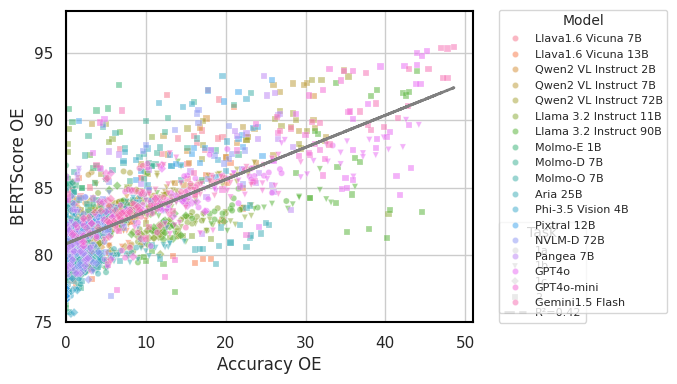

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="colorblind")

# Create a figure with a specified size
plt.figure(figsize=(7, 4))

# Define markers for different tasks
markers = {'1a': 'o', '1b': 'v', '1c': 'D', '2': 's'}

# Scatter plot with customization
scatter = sns.scatterplot(
    data=df, x='acc_oe', y='bert', hue='model',
    style='task', markers=markers,
    s=20, alpha=0.5
)

# Perform linear regression and get the parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(df['acc_oe'], df['bert'])
r_squared = r_value ** 2

# Create a line based on the regression
x_vals = np.array(df['acc_oe'])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='grey', linestyle='--', linewidth=2.0, label=f'R²={r_squared:.2f}')  # Increased linewidth

# Set labels and their font sizes
plt.xlabel('Accuracy OE', fontsize=12)
plt.ylabel('BERTScore OE', fontsize=12)

# Define the limits of the axes
plt.xlim(left=0.0)
plt.ylim(bottom=75.0)

# Access the current axes, enabling modification of aspects like spines
ax = plt.gca()

# Ensure all borders are visible and set their properties
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)  # Increased linewidth for visibility
    spine.set_color('black')

# Retrieve handles and labels for the legend
handles, labels = scatter.get_legend_handles_labels()

# Filter out 'model' and 'task' from labels and handles
filtered_handles_labels = [(handle, label) for handle, label in zip(handles, labels) if label.lower() not in ['model', 'task']]
filtered_handles, filtered_labels = zip(*filtered_handles_labels)

# Create separate legends for 'model' and 'task'
num_models = len(df['model'].unique())
legend_task = ax.legend(filtered_handles[num_models:], filtered_labels[num_models:], title='Task', loc='upper left', bbox_to_anchor=(1.05, 0.34), fontsize=8, title_fontsize=10)
legend_model = ax.legend(filtered_handles[:num_models], filtered_labels[:num_models], title='Model', loc='upper left', bbox_to_anchor=(1.05, 1.02), fontsize=8, title_fontsize=10)


# Manually add the first legend back
ax.add_artist(legend_task)

# Display the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_107959/2547128665.py:19: UserWarning: 
The palette list has fewer values (15) than needed (18) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(


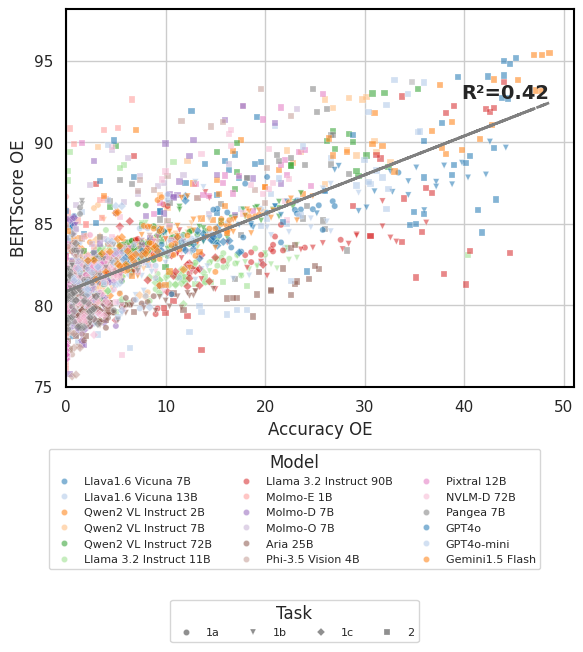

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Define a distinct color palette for 15 models
palette = sns.color_palette("tab20", n_colors=15)  # Use the "tab20" palette for up to 20 distinct colors

# Create a figure with a specified size
plt.figure(figsize=(6, 8))

# Define markers for different tasks
markers = {'1a': 'o', '1b': 'v', '1c': 'D', '2': 's'}

# Scatter plot with customization and distinct colors
scatter = sns.scatterplot(
    data=df, x='acc_oe', y='bert', hue='model',
    palette=palette,  # Use the defined palette
    style='task', markers=markers,
    s=20, alpha=0.55
)

# Perform linear regression and get the parameters
slope, intercept, r_value, p_value, std_err = stats.linregress(df['acc_oe'], df['bert'])
r_squared = r_value ** 2

# Create a line based on the regression
x_vals = np.array(df['acc_oe'])
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='grey', linestyle='--', linewidth=2.0, label=f'R²={r_squared:.2f}')  # Increased linewidth

# Set labels and their font sizes
plt.xlabel('Accuracy OE', fontsize=12)
plt.ylabel('BERTScore OE', fontsize=12)

# Define the limits of the axes
plt.xlim(left=0.0)
plt.ylim(bottom=75.0)

# Access the current axes, enabling modification of aspects like spines
ax = plt.gca()

# Ensure all borders are visible and set their properties
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)  # Increased linewidth for visibility
    spine.set_color('black')

# Retrieve handles and labels for the legend
handles, labels = scatter.get_legend_handles_labels()

# Filter out 'model' and 'task' from labels and handles
filtered_handles_labels = [(handle, label) for handle, label in zip(handles, labels) if label.lower() not in ['model', 'task']]
filtered_handles, filtered_labels = zip(*filtered_handles_labels)

# Number of unique models
num_models = len(df['model'].unique())

# Create the first legend for 'model', 3 columns wide
legend_model = ax.legend(
    filtered_handles[:num_models], filtered_labels[:num_models], 
    title='Model', loc='upper center', bbox_to_anchor=(0.45, -0.15), ncol=3, fontsize=8, title_fontsize=12
)

# Create the second legend for 'task'
legend_task = ax.legend(
    filtered_handles[num_models:-1], filtered_labels[num_models:-1], 
    title='Task', loc='upper center', bbox_to_anchor=(0.45, -0.55), ncol=4, fontsize=8, title_fontsize=12
)

ax.add_artist(legend_model)

# Add the R^2 value at the end of the regression line
x_text = x_vals.max()  # Use the max value on the x-axis
y_text = slope * x_text + intercept  # Corresponding y value from the regression line
plt.text(x_text, y_text, f'R²={r_squared:.2f}', fontsize=14, fontweight='bold', verticalalignment='bottom', horizontalalignment='right')

plt.tight_layout()
plt.savefig('scatterplot.png', dpi=300)
plt.show()
